<a href="https://colab.research.google.com/github/pimbrouwer/GenISP-G76/blob/master/fullCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Need to run this once when starting to work 


In [ ]:
#Bij boot

!pip install rawpy
!git clone https://github.com/pimbrouwer/GenISP-G76.git
!mkdir modelResults

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.6 MB/s eta 0:00:00


Lekker neuraal netwerkie

The Length of Train set is : 100


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:02<00:00, 58.0MB/s]


Epoch: 1/15, Iter: 2/10,  Loss: 2.2429
Epoch: 1/15, Iter: 4/10,  Loss: 2.6041
Epoch: 1/15, Iter: 6/10,  Loss: 1.3379
Epoch: 1/15, Iter: 8/10,  Loss: 1.3023
Epoch: 1/15, Iter: 10/10,  Loss: 1.2021
Epoch: 2/15, Iter: 2/10,  Loss: 1.0483
Epoch: 2/15, Iter: 4/10,  Loss: 1.1668
Epoch: 2/15, Iter: 6/10,  Loss: 0.9427
Epoch: 2/15, Iter: 8/10,  Loss: 1.0429
Epoch: 2/15, Iter: 10/10,  Loss: 1.4143
Epoch: 3/15, Iter: 2/10,  Loss: 0.8851
Epoch: 3/15, Iter: 4/10,  Loss: 1.2068
Epoch: 3/15, Iter: 6/10,  Loss: 0.9329
Epoch: 3/15, Iter: 8/10,  Loss: 1.0093
Epoch: 3/15, Iter: 10/10,  Loss: 1.0084
Epoch: 4/15, Iter: 2/10,  Loss: 0.9089
Epoch: 4/15, Iter: 4/10,  Loss: 1.3318
Epoch: 4/15, Iter: 6/10,  Loss: 0.7162
Epoch: 4/15, Iter: 8/10,  Loss: 0.9887
Epoch: 4/15, Iter: 10/10,  Loss: 0.8656
Epoch: 5/15, Iter: 2/10,  Loss: 1.0199
Epoch: 5/15, Iter: 4/10,  Loss: 1.2595
Epoch: 5/15, Iter: 6/10,  Loss: 0.7414
Epoch: 5/15, Iter: 8/10,  Loss: 1.0098
Epoch: 5/15, Iter: 10/10,  Loss: 0.9923
Epoch: 6/15, Iter: 2

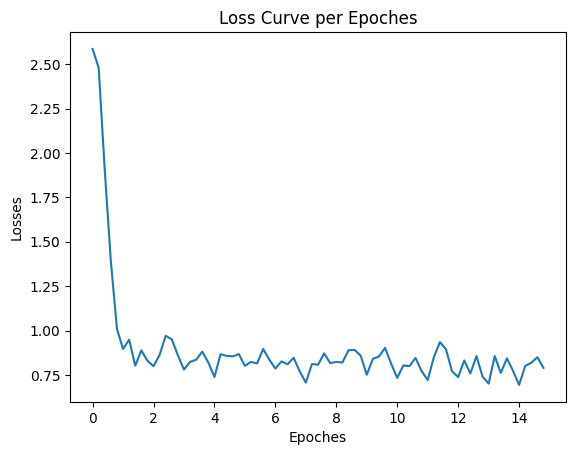

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import rawpy
import numpy as np
import json
import os

from torchvision import transforms
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

convert_tensor = transforms.ToTensor()
json_file_path_train = '/content/GenISP-G76/test100.json'
root_dir_train = '/content/GenISP-G76'
json_file_path_test = '/content/GenISP-G76/val25.json'
root_dir_test = '/content/GenISP-G76'

batch_size = 10
num_epochs = 15
stepSize = 2

printImage = False
printWB = False
printCC = False
printSH = False
printTrain = False

class preprocessor(object):
  def __call__(self, image):
    new_h = 800
    new_w = 1333

    raw = rawpy.imread(image)
    rgb = raw.postprocess()
    convert_tensor = transforms.ToTensor()
    resize = T.Resize((new_h,new_w), antialias=True)
    img = resize(convert_tensor(rgb))

    if printImage is True:
      print(img.shape)
    
    return img.requires_grad_(), new_h, new_w

transform = T.ToPILImage()

class genISPDataset(Dataset):
  def __init__(self, json_file, root_dir, transform=preprocessor()):
    with open(json_file, 'r') as f:
      self.data = json.load(f)
      self.root_dir = root_dir
      self.transform = transform

  def __len__(self):
    return len(self.data['images'])

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name = os.path.join(self.root_dir,
                            self.data['images'][idx]['id'])
    
    if self.transform:
      image, new_h, new_w = self.transform(img_name + '.NEF')

    sample = {'image': image, 'img_name': self.data['images'][idx]['id'], 'scaling_h': new_h / self.data['images'][idx]['height'], 'scaling_w': new_w / self.data['images'][idx]['width']}

    return sample

def groundTruthData(json_file, image, scaling_h, scaling_w):
  with open(json_file, 'r') as f:
    data = json.load(f)

  boxes = torch.FloatTensor([[0, 0 ,0 ,0]])
  labels = torch.LongTensor([0])

  for item in data['annotations']:
    if item.get('image_id') == image:
      box_temp = torch.FloatTensor([[item['bbox'][0] * scaling_w, 
                                      item['bbox'][1] * scaling_h, 
                                      (item['bbox'][0] + item['bbox'][2]) * scaling_w, 
                                      (item['bbox'][1] + item['bbox'][3]) * scaling_h]])
      
      labels_temp = torch.LongTensor([item['category_id']])

      boxes = torch.cat((boxes, box_temp))
      labels = torch.cat((labels, labels_temp))

  return [{"boxes": boxes[1:,:], "labels": labels[1:]}]

genISP_dataset_train = genISPDataset(json_file = json_file_path_train,
                               root_dir = root_dir_train)
genISP_dataset_test = genISPDataset(json_file = json_file_path_test,
                               root_dir = root_dir_test)

print('The Length of Train set is : {}'.format(len(genISP_dataset_train)))

train_loader = torch.utils.data.DataLoader(dataset=genISP_dataset_train, 
                                           batch_size=batch_size,            
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=genISP_dataset_test, 
                                           batch_size=batch_size,            
                                           shuffle=False)

resnetModel = torchvision.models.detection.retinanet_resnet50_fpn(weights='COCO_V1')

for param in resnetModel.parameters():
    param.requires_grad = False

class convWB(nn.Module):
  def __init__(self):
    super(convWB, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.leakyReLU = nn.LeakyReLU(0.1)
    self.maxPool1 = nn.MaxPool2d(kernel_size=7, stride=1)
    self.maxPool2 = nn.MaxPool2d(kernel_size=5, stride=1)
    self.maxPool3 = nn.MaxPool2d(kernel_size=3, stride=1)
    self.avgAdaptPool = nn.AdaptiveAvgPool2d(1)
    self.mlp = nn.Linear(128, 3)

  def forward(self, x):
    out = nn.functional.interpolate(input=x, size=256)

    if printWB is True:
      print('Shape after interpolaten, {}'.format(out.shape))

    out = self.conv1(out)
    out = self.leakyReLU(out)
    out = self.maxPool1(out)

    if printWB is True:
      print('WB-First pool, {}'.format(out.shape))

    out = self.conv2(out)
    out = self.leakyReLU(out)
    out = self.maxPool2(out)

    if printWB is True:
      print('WB-Second pool, {}'.format(out.shape))

    out = self.conv3(out)
    out = self.leakyReLU(out)

    if printWB is True:
      print('WB-Third pool, {}'.format(out.shape))

    out = self.maxPool3(out)
    out = self.avgAdaptPool(out).flatten(start_dim=1, end_dim=-1)

    if printWB is True:
      print('WB-Flattened, {}'.format(out.shape))
    
    out = self.mlp(out)

    if printWB is True:
      print('End ConvWB, {}'.format(out.shape))

    wb = x.clone()
    for i in range(len(out)):
      wb[i, 0, :, :] = x[i, 0, :, :] * out[i, 0]
      wb[i, 1, :, :] = x[i, 1, :, :] * out[i, 1]
      wb[i, 2, :, :] = x[i, 2, :, :] * out[i, 2]
        
    if printWB is True:
      print('Whitebalanced, {}'.format(wb.shape))
      print(wb)

    return wb

class convCC(nn.Module):
  def __init__(self):
    super(convCC, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.leakyReLU = nn.LeakyReLU(0.1)
    self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=1)
    self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=1)
    self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=1)
    self.avgAdaptPool = nn.AdaptiveAvgPool2d(1)
    self.mlp = nn.Linear(128, 9)

  def forward(self, x):
    out = nn.functional.interpolate(input=x, size=256)

    if printCC is True:
      print('Shape after interpolaten, {}'.format(out.shape))

    out = self.conv1(out)
    out = self.leakyReLU(out)
    out = self.maxPool1(out)

    if printCC is True:
      print('CC-First pool, {}'.format(out.shape))
    
    out = self.conv2(out)
    out = self.leakyReLU(out)
    out = self.maxPool2(out)
    
    if printCC is True:
      print('CC-Second pool, {}'.format(out.shape))
    
    out = self.conv3(out)
    out = self.leakyReLU(out)
    out = self.maxPool3(out)
    
    if printCC is True:
      print('CC-Third pool, {}'.format(out.shape))
    
    out = self.avgAdaptPool(out).flatten(start_dim=1, end_dim=-1)
    
    if printCC is True:
      print('CC-Flattened, {}'.format(out.shape))
    
    out = self.mlp(out)
    
    if printCC is True:
      print('End ConvCC, {}'.format(out.shape))

    cc = x.clone()
    for i in range(len(out)):
      cc[i,0,:,:] = x[i,0,:,:]*out[i,0] + x[i,1,:,:]*out[i,1] + x[i,2,:,:]*out[i,2]
      cc[i,1,:,:] = x[i,0,:,:]*out[i,3] + x[i,1,:,:]*out[i,4] + x[i,2,:,:]*out[i,5]
      cc[i,2,:,:] = x[i,0,:,:]*out[i,6] + x[i,1,:,:]*out[i,7] + x[i,2,:,:]*out[i,8]

    if printCC is True:
      print('Colourcorrected, {}'.format(cc.shape))
    
    return cc

class convShallow(nn.Module):
  def __init__(self):
    super(convShallow, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0)
    self.instNorm = nn.InstanceNorm2d(100)
    self.leakyReLU = nn.LeakyReLU(0.1)

  def forward(self, x):
    out = self.conv1(x)
    out = self.instNorm(out)
    out = self.leakyReLU(out)

    if printSH is True:
      print('SH-First ReLU, {}'.format(out.shape))
    
    out = self.conv2(out)
    out = self.instNorm(out)
    out = self.leakyReLU(out)
    
    if printSH is True:
      print('SH-Second ReLU, {}'.format(out.shape))
    
    out = self.conv3(out)
    
    if printSH is True:
      print('End ConvSh, {}'.format(out.shape))

    return out

modelConvWB = convWB()
modelConvCC = convCC()
modelConvShallow = convShallow()

modelConvWB.train()
modelConvCC.train()
modelConvShallow.train()

resnetModel.train()

optimizer = torch.optim.Adam([
                {'params': modelConvWB.parameters()},
                {'params': modelConvCC.parameters()},
                {'params': modelConvShallow.parameters()}
                ]
            , lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

losses = []

for epoch in range(num_epochs):
  for i, batch in enumerate(train_loader, 0):
    images, img_name, img_scale_h, img_scale_w = batch['image'], batch['img_name'], batch['scaling_h'], batch['scaling_w']

    optimizer.zero_grad()
    
    image_wb = modelConvWB(images)
    image_cc = modelConvCC(image_wb)
    image_sh = modelConvShallow(image_cc)

    loss_cls_batch = None

    for j in range(len(image_sh)):
      imageSingle = torch.unsqueeze(image_sh[j,:,:,:], 0)
      output = resnetModel(imageSingle, groundTruthData(json_file_path_train, img_name[j], img_scale_h[j], img_scale_w[j]))

      if printTrain is True:
        print('Loss for image {}-{}: {}, {}'.format(i, j, output['classification'], output['bbox_regression']))

      if loss_cls_batch == None: 
        loss_cls_batch = output['classification'].unsqueeze(0)
        loss_reg_batch = output['bbox_regression'].unsqueeze(0)
      else:
        loss_cls_batch = torch.cat((loss_cls_batch, output['classification'].unsqueeze(0)))
        loss_reg_batch = torch.cat((loss_reg_batch, output['bbox_regression'].unsqueeze(0)))
    
    
    loss_cls = torch.mean(loss_cls_batch)
    loss_reg = torch.mean(loss_reg_batch)
    loss = loss_cls + loss_reg

    if printTrain is True:
      print('Losses for this batch: {}, {} and {}'.format(loss_cls, loss_reg, loss))
    
    loss.backward()

    if printTrain is True:
      print('De drie gradients van iedere image {}, {} en {}'.format(image_wb.grad, image_cc.grad, image_sh.grad))
    
    optimizer.step()
    
    losses.append(loss.item())
          
    if (i+1) % stepSize == 0:
        print ('Epoch: %d/%d, Iter: %d/%d,  Loss: %.4f' 
                %(epoch+1, num_epochs, i+1,\
                  len(genISP_dataset_train)//batch_size, loss.item()))

torch.save(modelConvWB.state_dict(), '/content/modelResults/convWB.pt')
torch.save(modelConvCC.state_dict(), '/content/modelResults/convCC.pt')
torch.save(modelConvShallow.state_dict(), '/content/modelResults/convSH.pt')

modelConvWB.load_state_dict(torch.load('/content/modelResults/convWB.pt'))
modelConvCC.load_state_dict(torch.load('/content/modelResults/convCC.pt'))
modelConvShallow.load_state_dict(torch.load('/content/modelResults/convSH.pt'))

modelConvWB.eval()
modelConvCC.eval()
modelConvShallow.eval()
resnetModel.eval()

correct = 0
total = 0

for i, batch in enumerate(test_loader, 0):
  images, img_name, img_scale_h, img_scale_w = batch['image'], batch['img_name'], batch['scaling_h'], batch['scaling_w']

  image_wb = modelConvWB(images)
  image_cc = modelConvCC(image_wb)
  image_sh = modelConvShallow(image_cc)

  for j in range(len(image_sh)):
    imageSingle = torch.unsqueeze(image_sh[j,:,:,:], 0)
    output = resnetModel(image_sh)
    output = output[0]

    idx_list = []

    for idx, score in enumerate(output['scores']):
      if (score > 0.5) and (output['labels'][idx] < 4):
        #print(idx, score)
        idx_list.append(idx)
    
    output['boxes'] = output['boxes'][idx_list]
    output['labels'] = output['labels'][idx_list]
    output['scores'] = output['scores'][idx_list]
  
    groundTruth = groundTruthData(json_file_path_test, img_name[j], img_scale_h[j], img_scale_w[j])[0]

    total += len(groundTruth['labels'])

    labelCountTruth = torch.bincount(torch.cat((groundTruth['labels'], torch.LongTensor([4]))))
    labelCountTest = torch.bincount(torch.cat((output['labels'], torch.LongTensor([4]))))

    correct += len(groundTruth['labels']) - ((labelCountTruth[1] - labelCountTest[1]) + (labelCountTruth[2] - labelCountTest[2]) + (labelCountTruth[3] - labelCountTest[3]))

print('Test Accuracy of the model on the %d test images: %.2f %%' % (len(genISP_dataset_test), 100 * correct / total))

loss, xloss = losses[0::stepSize], (np.arange(0, len(losses), stepSize) / (len(genISP_dataset_train)//batch_size)).tolist()
plt.xlabel('Epoches')
plt.ylabel('Losses')
plt.title('Loss Curve per Epoches')
plt.plot(xloss, loss)
plt.show()

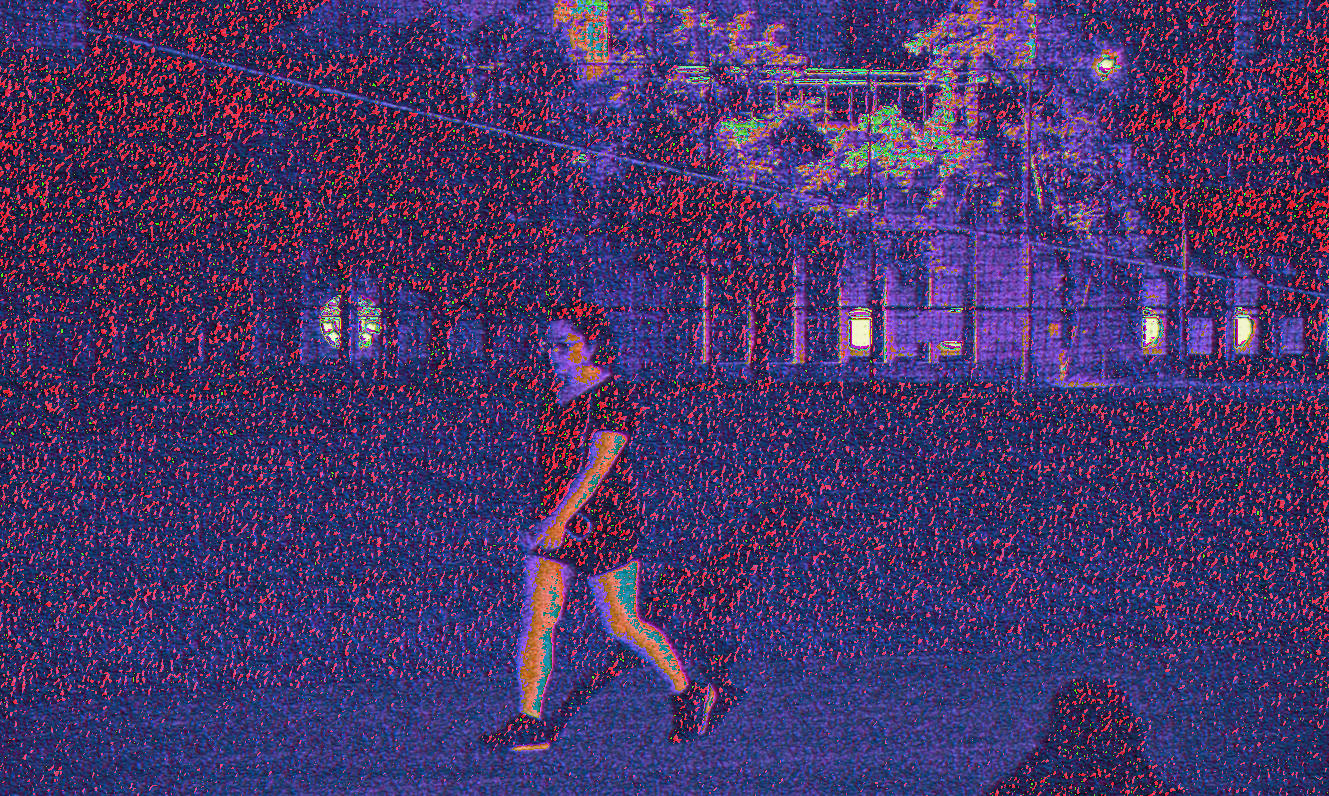

In [ ]:
import torchvision.transforms as T
from PIL import Image
transform = T.ToPILImage()
img = transform(imageSingle[0])
img.show()